## Summary
Notes for the sections of the mini-course, Manipulating Financial Data in Python:

 * 01-01 Reading and plotting stock data
 * 01-02 Working with multiple stocks
 * 01-03 The power of numpy
 * 01-04 Statistical analysis of time series
 * 01-05 Incomplete data
 * 01-06 Histograms and scatterplots
 * 01-07 Sharpe ratio and other portfolio statistics
 * 01-08 Optimzers: Building a parameterized model
 * 01-09 Optimzers: How to optimze a portfolio

## Table of Contents

 * [Setup](#Setup)
 * [Inspection of data](#Inspection-of-data)
 * [Join the data `prices`](#Join-the-data-prices)
 * [Prepare and normalise the dataset for analysis `norm`](#Prepare-and-normalise-the-dataset-for-analysis-norm)
 * [Statistical analysis `daily_returns`](#Statistical-analysis-daily_returns)
     * [Reset `daily_returns`](#Reset-daily_returns)
     * [Rolling returns `sma_20`](#Rolling-returns-sma_20)
     * [Rolling deviations `rdev_20`](#Rolling-deviations-rdev_20)
 * [Daily returns distributions](#Daily-returns-distributions)
     * [Alpha and beta](#Alpha-and-beta)
     * [Correlations](#Correlations)
 * [Sharpe ratio](#Sharpe-ratio)
     * [Sharpe ratio adjustment](#Sharpe-ratio-adjustment)
     * [Risk free rate adjustment](#Risk-free-rate-adjustment)
     * [Portfolio returns `rp`](#Portfolio-returns-rp)
     * [Risk free rate `rf`](#Risk-free-rate-rf)
     * [Sharpe ratio calculation `sr`](#Sharpe-ratio-calculation-sr)
 * [Optimising functions](#Optimising-functions)
     * [Optimisation ranges and constraints](#Optimisation-ranges-and-constraints)
     * [Framing the optimisation problem](#Framing-the-optimisation-problem)

## Version Control

In [1]:
%run ../../../code/version_check.py

Python: 3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, 21:13:27) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

matplotlib:	2.0.0
numpy:		1.12.0
pandas:		0.19.2
quandl:		3.0.1
sklearn:	0.18.1
scipy:		0.18.1
statsmodels:	0.8.0


## Change Log
    Date Created: 2017-02-28
    
    Date of Change    Change Notes
    --------------    ----------------------------------------------------------------
    2017-02-28        Initial draft


---

## Setup

Import needed modules and establish control variables.

In [2]:
%matplotlib inline

import datetime
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_datareader.data as web
import quandl
import scipy.optimize as spo

The `dates` variable will be a `datetime index` used for joining the time series we download.

In [3]:
start_date = datetime.datetime(1999, 1, 1)
end_date = datetime.datetime(2017, 2, 27)

dates = pd.date_range(start_date, end_date)

We download `spy` to use as a benchmark, and also as a reference point to determine if the market is open. It's generally safe to say that if the market was open, then `spy` would have been traded.

The time series are downloaded into their own dataframe, as opposed to using the `pandas.datareader` functionality to download into a panel.

In [4]:
spy = web.DataReader("SPY", 'yahoo', start_date, end_date)
aapl = web.DataReader("AAPL", 'yahoo', start_date, end_date)
gld = web.DataReader("GLD", 'yahoo', start_date, end_date)
ibm = web.DataReader("IBM", 'yahoo', start_date, end_date)
xom = web.DataReader("XOM", 'yahoo', start_date, end_date)

Assumptions used throughout analysis

In [5]:
n_trading_days = 252

Used for formatting of charts

In [6]:
ts_figsize = (10, 3)
subplot_figsize = (10, 8)
square_figsize = (5, 5)

rcParams['grid.alpha'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['axes.spines.left'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['legend.loc'] = 'best'
rcParams['legend.fancybox'] = True
rcParams['ytick.left'] = False

ts_kwargs = {'figsize': ts_figsize, 'grid': True}
subplot_kwargs = {'figsize': subplot_figsize, 'grid': True, 'subplots': True, }
legend_kwargs = {'bbox_to_anchor': (1.05, 1), 'loc': 2, 'borderaxespad': 0.}

Used for the quandl module to prevent daily download limits

In [7]:
quandl_api_key = os.environ['QUANDL_API_KEY']
quandl.ApiConfig.api_key = quandl_api_key

[[Top]](#Table-of-Contents)

---

## Inspection of data

We see that:
 
 * `['spy', 'aapl', 'ibm', 'xom']` series have the same number of observations = 4,566
 * `['spy', 'aapl', 'ibm', 'xom']` series start date = 1999-01-04
 * `gld` starts 2004-11-18 and has 3,089 observations
 * Approximately 250 KB is used for each dataset (`gld`: 170 KB)

In [8]:
print(spy.info())
print(spy.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4567 entries, 1999-01-04 to 2017-02-27
Data columns (total 6 columns):
Open         4567 non-null float64
High         4567 non-null float64
Low          4567 non-null float64
Close        4567 non-null float64
Volume       4567 non-null int64
Adj Close    4567 non-null float64
dtypes: float64(5), int64(1)
memory usage: 249.8 KB
None
                Open        High         Low       Close   Volume  Adj Close
Date                                                                        
1999-01-04  123.3750  125.218697  121.718697  123.031197  9450400  88.568877
1999-01-05  122.9375  124.875000  122.937500  124.437500  8031000  89.581260
1999-01-06  125.8125  127.750000  125.750000  127.437500  7737700  91.740929
1999-01-07  126.3750  127.218697  125.781197  126.812500  5504900  91.290998
1999-01-08  128.1875  128.500000  125.968697  127.750000  6224400  91.965894


In [9]:
print(aapl.info())
print(aapl.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4567 entries, 1999-01-04 to 2017-02-27
Data columns (total 6 columns):
Open         4567 non-null float64
High         4567 non-null float64
Low          4567 non-null float64
Close        4567 non-null float64
Volume       4567 non-null int64
Adj Close    4567 non-null float64
dtypes: float64(5), int64(1)
memory usage: 249.8 KB
None
                 Open       High        Low      Close     Volume  Adj Close
Date                                                                        
1999-01-04  42.125000  42.249999  40.000001  41.250000  238221200   1.336083
1999-01-05  41.937499  43.937501  41.499999  43.312500  352528400   1.402887
1999-01-06  44.124999  44.124999  41.000000  41.750001  337142400   1.352278
1999-01-07  42.249999  45.062500  42.125000  44.999999  357254800   1.457545
1999-01-08  46.562501  46.875001  43.999999  44.999999  169708000   1.457545


In [10]:
print(gld.info())
print(gld.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3089 entries, 2004-11-18 to 2017-02-27
Data columns (total 6 columns):
Open         3089 non-null float64
High         3089 non-null float64
Low          3089 non-null float64
Close        3089 non-null float64
Volume       3089 non-null int64
Adj Close    3089 non-null float64
dtypes: float64(5), int64(1)
memory usage: 168.9 KB
None
                 Open       High        Low      Close    Volume  Adj Close
Date                                                                       
2004-11-18  44.430000  44.490002  44.070000  44.380001   5992000  44.380001
2004-11-19  44.490002  44.919998  44.470001  44.779999  11655300  44.779999
2004-11-22  44.750000  44.970001  44.740002  44.950001  11996000  44.950001
2004-11-23  44.880001  44.919998  44.720001  44.750000   3169200  44.750000
2004-11-24  44.930000  45.049999  44.790001  45.049999   6105100  45.049999


In [11]:
print(ibm.info())
print(ibm.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4567 entries, 1999-01-04 to 2017-02-27
Data columns (total 6 columns):
Open         4567 non-null float64
High         4567 non-null float64
Low          4567 non-null float64
Close        4567 non-null float64
Volume       4567 non-null int64
Adj Close    4567 non-null float64
dtypes: float64(5), int64(1)
memory usage: 249.8 KB
None
                Open     High       Low     Close   Volume  Adj Close
Date                                                                 
1999-01-04  185.0000  186.500  181.5000  183.0000  8149600  68.896421
1999-01-05  183.0000  189.875  182.8125  189.6250  9907600  71.390622
1999-01-06  190.3125  192.750  188.5000  188.7500  9539600  71.061199
1999-01-07  187.9375  192.375  187.0000  190.1875  8306800  71.602393
1999-01-08  191.0000  192.000  185.6250  187.5625  9176800  70.614125


In [12]:
print(xom.info())
print(xom.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4567 entries, 1999-01-04 to 2017-02-27
Data columns (total 6 columns):
Open         4567 non-null float64
High         4567 non-null float64
Low          4567 non-null float64
Close        4567 non-null float64
Volume       4567 non-null int64
Adj Close    4567 non-null float64
dtypes: float64(5), int64(1)
memory usage: 249.8 KB
None
               Open     High      Low    Close   Volume  Adj Close
Date                                                              
1999-01-04  72.7500  74.1250  72.2500  72.6250  8853600  23.225691
1999-01-05  72.5000  72.9375  71.6875  72.0000  6652800  23.025814
1999-01-06  73.1250  75.8125  72.6875  74.8750  9965600  23.945247
1999-01-07  74.4375  74.9375  73.7500  74.7500  7417200  23.905272
1999-01-08  74.2500  74.6875  72.9375  74.3125  6343400  23.765358


[[Top]](#Table-of-Contents)

---

## Join the data `prices`

In [13]:
# create empty dataframe with datetime index set
prices = pd.DataFrame(index=dates)

# add spy 'Adj Close' column and rename to the column to 'spy'
# only keeping those rows where price data exists for spy
# to ensure we are analysing days where the market was open
prices = prices.join(spy['Adj Close'], how='inner')
prices = prices.rename(columns={'Adj Close': 'spy'})

# review changes
print(prices.info())
print(prices.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4567 entries, 1999-01-04 to 2017-02-27
Data columns (total 1 columns):
spy    4567 non-null float64
dtypes: float64(1)
memory usage: 71.4 KB
None
                  spy
1999-01-04  88.568877
1999-01-05  89.581260
1999-01-06  91.740929
1999-01-07  91.290998
1999-01-08  91.965894


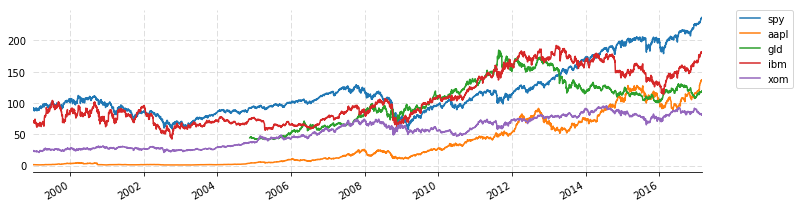

In [14]:
# add aapl, ibm, gld, xom
prices['aapl'] =  aapl['Adj Close']
prices['gld'] =  gld['Adj Close']
prices['ibm'] =  ibm['Adj Close']
prices['xom'] =  xom['Adj Close']

# visualise the price data
prices.plot(**ts_kwargs)
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

---

## Prepare and normalise the dataset for analysis `norm`


Use forward-fill first before back-fill. This is done to prevent data from the future creeping into past results. We only use the backfill to allow for time series that start part-way through the defined index time window to have the start of their data series aligned with the rest of the data.

In [15]:
# fill gaps
norm = prices.copy()
norm.fillna(method='ffill', axis=0, inplace=True)
norm.fillna(method='bfill', axis=0, inplace=True)

# normalise the price data
norm = norm / norm.ix[0]

#  review changes
print(norm.head())

                 spy      aapl  gld       ibm       xom
1999-01-04  1.000000  1.000000  1.0  1.000000  1.000000
1999-01-05  1.011430  1.050000  1.0  1.036202  0.991394
1999-01-06  1.035815  1.012121  1.0  1.031421  1.030981
1999-01-07  1.030735  1.090909  1.0  1.039276  1.029260
1999-01-08  1.038355  1.090909  1.0  1.024932  1.023236


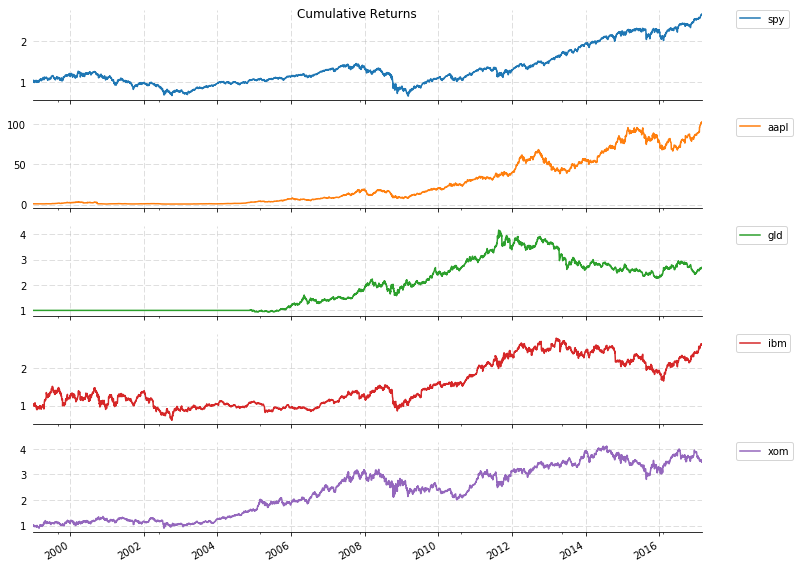

In [16]:
# generate plot
norm.plot(title='Cumulative Returns', **subplot_kwargs)

[ax.legend(**legend_kwargs) for ax in plt.gcf().axes]
plt.tight_layout()
plt.show()

When viewing the series all together we can see the easily see the outsized gains `aapl` had compartive to the market (`spy`) and `ibm`.

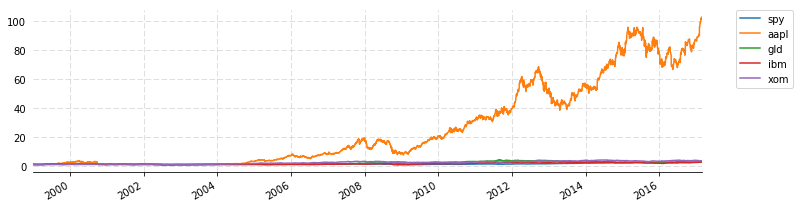

In [17]:
# generate plot to show the outsized returns aapl had relative the others
norm.plot.line(**ts_kwargs)

plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

---

## Statistical analysis `daily_returns`

In [18]:
daily_returns = prices.pct_change()
print(daily_returns.head())

                 spy      aapl  gld       ibm       xom
1999-01-04       NaN       NaN  NaN       NaN       NaN
1999-01-05  0.011430  0.050000  NaN  0.036202 -0.008606
1999-01-06  0.024108 -0.036075  NaN -0.004614  0.039931
1999-01-07 -0.004904  0.077844  NaN  0.007616 -0.001669
1999-01-08  0.007393  0.000000  NaN -0.013802 -0.005853


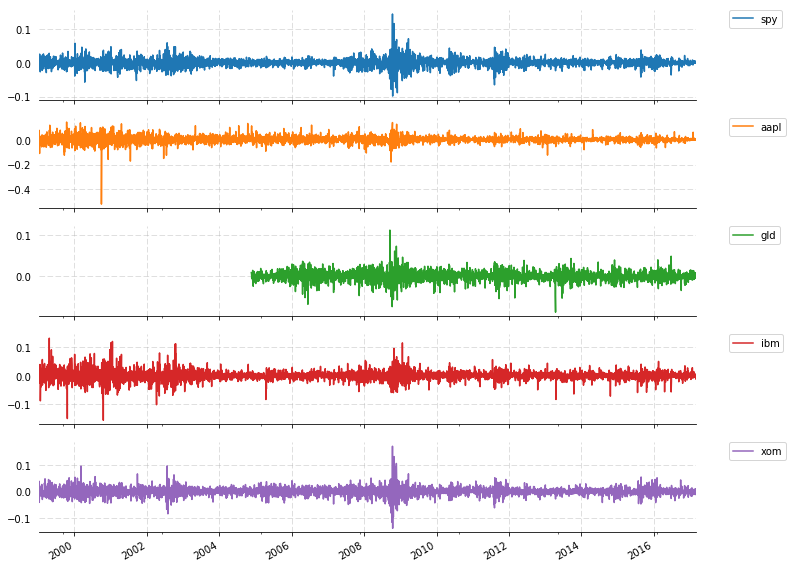

In [19]:
daily_returns.plot(**subplot_kwargs)

[ax.legend(**legend_kwargs) for ax in plt.gcf().axes]
plt.tight_layout()
plt.show()

In [20]:
mean = daily_returns.mean()
mean

spy     0.000293
aapl    0.001406
gld     0.000395
ibm     0.000359
xom     0.000398
dtype: float64

In [21]:
std = daily_returns.std()
std

spy     0.012403
aapl    0.027374
gld     0.012284
ibm     0.017272
xom     0.015684
dtype: float64

In [22]:
# the mean series object can be still be indexed into using the series name
mean['spy']

0.00029252861080326773

[[Top]](#Table-of-Contents)

### Reset `daily_returns`

Here we reset the `daily_returns` to the precent change of the normalised dataframe, `norm`. We do this to as we've already processed it for forward-fill, and back-fill. This allows every row of the data frame to be used by the dataframe methods without running into issues of dealing with `Nan` values.

In [23]:
# reset daily_returns to use the normalised data now so the NaNa don't interfere
daily_returns = norm.pct_change()
daily_returns = daily_returns.dropna()
print(daily_returns.head())

                 spy      aapl  gld       ibm       xom
1999-01-05  0.011430  0.050000  0.0  0.036202 -0.008606
1999-01-06  0.024108 -0.036075  0.0 -0.004614  0.039931
1999-01-07 -0.004904  0.077844  0.0  0.007616 -0.001669
1999-01-08  0.007393  0.000000  0.0 -0.013802 -0.005853
1999-01-11 -0.009541  0.019444  0.0  0.008997 -0.041211


In [24]:
# global min and max, using '.values' converts to a numpy array
min = daily_returns.values.min()
max = daily_returns.values.max()
print('({}, {})'.format(min, max))

(-0.5186916535044109, 0.17190508626522827)


[[Top]](#Table-of-Contents)

### Rolling returns `sma_20`

Smoothed curve of the returns over a 20 day window. Later used to create Bollinger bands. Often used as a technical indicator and overlayed on the price series.

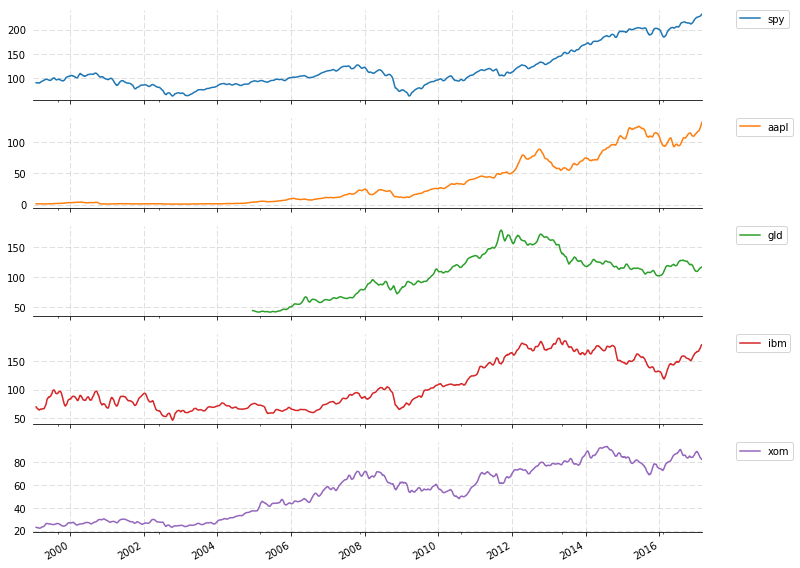

In [25]:
# sma is the "simple moving average"
sma_20 = prices.rolling(center=False, window=20).mean()
sma_20.plot(**subplot_kwargs)

[ax.legend(**legend_kwargs) for ax in plt.gcf().axes]
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

### Rolling deviations `rdev_20`

Will always have a positive value, calculated over a window of 20 days. Later used to create Bollinger bands.

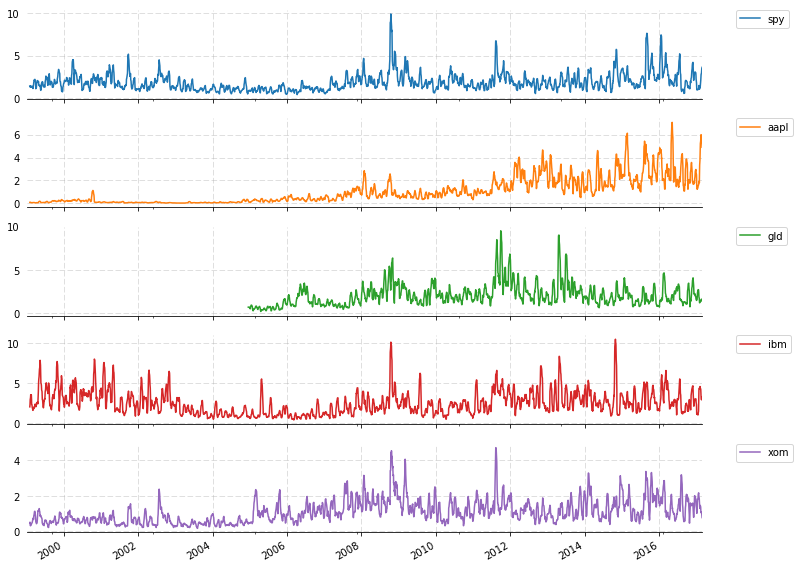

In [26]:
# rdev is the "rolling deviations"
rdev_20 = prices.rolling(center=False, window=20).std()
rdev_20.plot(**subplot_kwargs)

[ax.legend(**legend_kwargs) for ax in plt.gcf().axes]
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

### Bollinger bands

Bollinger bands are a way to view the current price relative to the current volatility. They are used as a technical indicator, and may be used in trading strategies.

When plotting, only the last 200 days of the price series are shown, to allow for better clarity of their visual representation.

In [27]:
upper_band = sma_20 + rdev_20 * 2
lower_band = sma_20 - rdev_20 * 2

/home/adrian/miniconda3/envs/ds_ml_portfolio/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


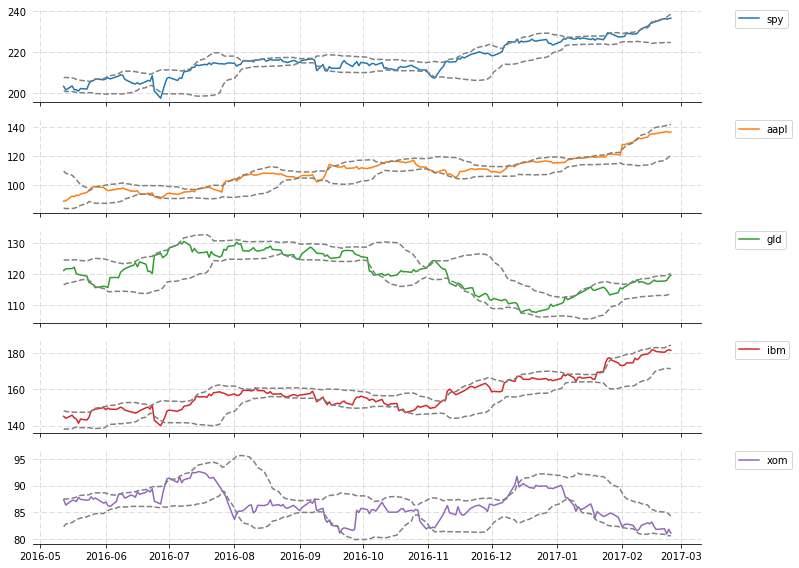

In [28]:
n_subplot_rows = len(prices.columns)
fig = plt.figure(figsize=subplot_figsize, tight_layout=True)

for i, series in enumerate(prices.columns):
    colour = 'C' + str(i)
    label = series + ' (200 most recent trading days)'
    subplot = i + 1
    
    ax = fig.add_subplot(n_subplot_rows, 1, subplot)
    
    ax.plot(prices[series][-200:-1], label=series, color=colour)
    ax.plot(upper_band[series][-200:-1], linestyle='dashed', color='grey', label='')
    ax.plot(lower_band[series][-200:-1], linestyle='dashed', color='grey', label='')
    ax.grid()
    
    if subplot != n_subplot_rows:
        ax.xaxis.set_ticklabels([])
        
    ax.legend(**legend_kwargs)
    

[[Top]](#Table-of-Contents)

---

## Daily returns distributions

Plot a histogram of `spy` daily returns, along with its mean and 2 standard deviations (upper and lower bounds)

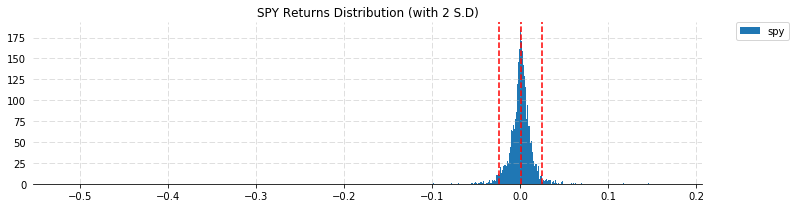

In [29]:
# plot returns distribution and mark with the mean and 2 std. dev.
series = 'spy'
daily_returns[series].hist(label=series, bins=1000, range=[min, max], align='mid', **ts_kwargs)

# mean
plt.axvline(mean[series], color='r', linestyle='dashed')

# upper deviation
plt.axvline(mean[series] + std[series] * 2, color='r', linestyle='dashed')

# lower deviation
plt.axvline(mean[series] - std[series] * 2, color='r', linestyle='dashed')

plt.title('SPY Returns Distribution (with 2 S.D)')
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

Overlay the histograms of `spy` and `aapl` to compare return distributions.

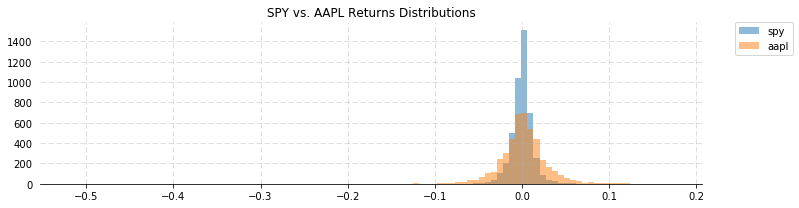

In [30]:
daily_returns['spy'].hist(label='spy',
                          bins=100,
                          range=[min, max],
                          align='mid',
                          alpha=0.5,
                          **ts_kwargs)

daily_returns['aapl'].hist(label='aapl',
                           bins=100,
                           range=[min, max],
                           align='mid',
                           alpha=0.5,
                           **ts_kwargs)

plt.title('SPY vs. AAPL Returns Distributions')
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

Use a binned histogram to view the shape of the returns distribution

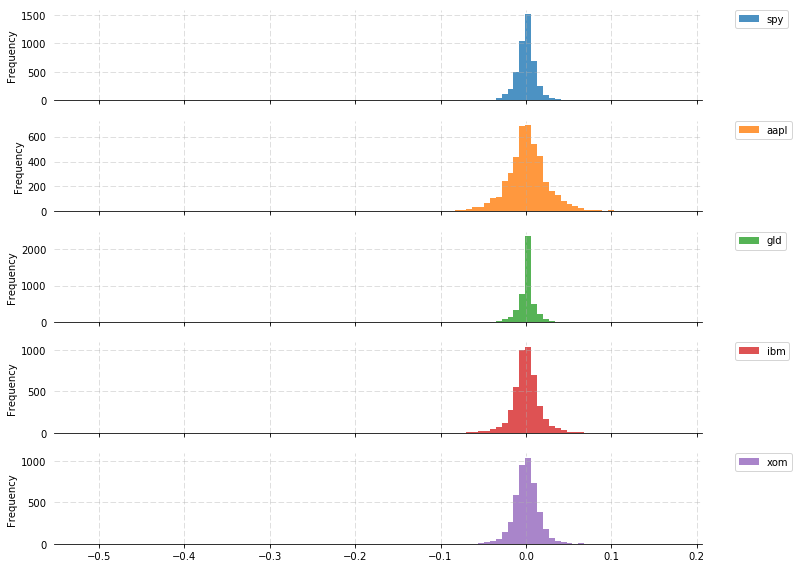

In [31]:
daily_returns.plot(kind='hist',
                   bins=100,
                   range=[min, max],
                   align='mid',
                   alpha=0.8,
                   **subplot_kwargs)

[ax.legend(**legend_kwargs) for ax in plt.gcf().axes]
plt.tight_layout()
plt.show()

Often a better way to see the shape is to use the Kernel Density Estimator, as this provides a better view of the skew and kurtosis (if any).

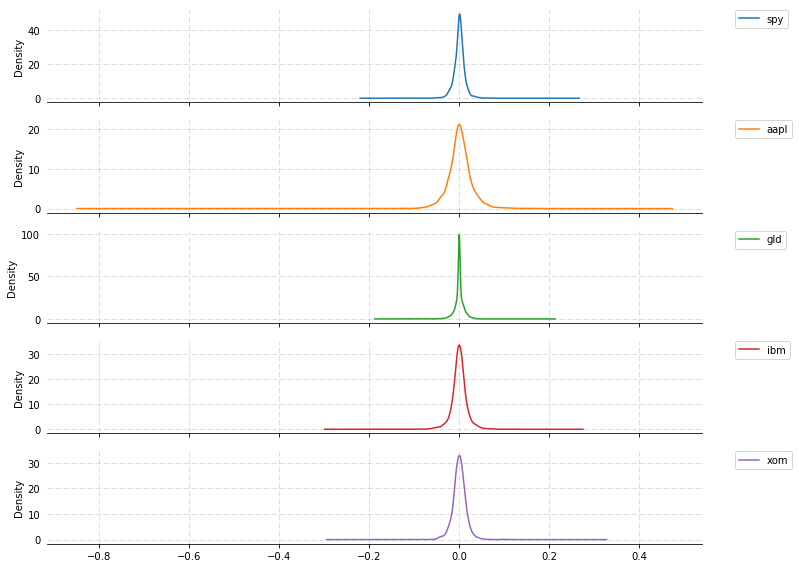

In [32]:
daily_returns.plot(kind='kde', **subplot_kwargs)

[ax.legend(**legend_kwargs) for ax in plt.gcf().axes]
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

### Alpha and beta 
$\alpha$ and $\beta$

(alpha = 0.001084164974513004)
(beta = 1.0995655577986292)


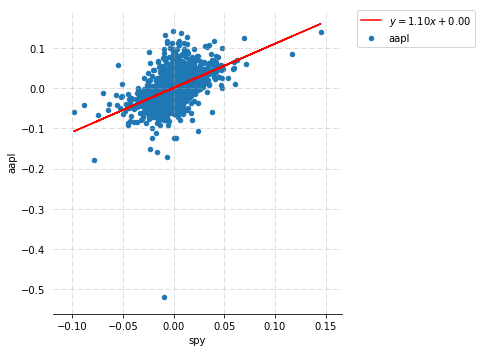

In [33]:
# the series to use to determine beta and alpha coeffecients
series = 'aapl'

# the series to benchmark returns against
benchmark = 'spy'

# create scatterplot
daily_returns.plot(kind='scatter', x=benchmark, y=series, figsize=square_figsize, label=series)

# create linear regression plot of series vs spy
beta, alpha = np.polyfit(x=daily_returns[benchmark], y=daily_returns[series], deg=1)

plt.plot(daily_returns[benchmark],
         beta * daily_returns[benchmark] + alpha,
         linestyle='-',
         color='r',
         label='$y = {0:.2f}x + {1:.2f}$'.format(beta, alpha))

print('(alpha = {})'.format(alpha))
print('(beta = {})'.format(beta))

plt.grid()
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

(alpha = 0.0002600367376648017)
(beta = 0.025051634369795586)


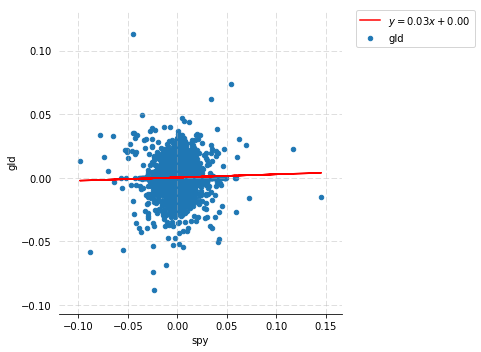

In [34]:
# the series to use to determine beta and alpha coeffecients
series = 'gld'

# the series to benchmark returns against
benchmark = 'spy'

# create scatterplot
daily_returns.plot(kind='scatter', x=benchmark, y=series, figsize=square_figsize, label=series)

# create linear regression plot of series vs spy
beta, alpha = np.polyfit(x=daily_returns[benchmark], y=daily_returns[series], deg=1)

plt.plot(daily_returns[benchmark],
         beta * daily_returns[benchmark] + alpha,
         linestyle='-',
         color='r',
         label='$y = {0:.2f}x + {1:.2f}$'.format(beta, alpha))

print('(alpha = {})'.format(alpha))
print('(beta = {})'.format(beta))

plt.grid()
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

(alpha = 0.00010952778893188873)
(beta = 0.852048905012624)


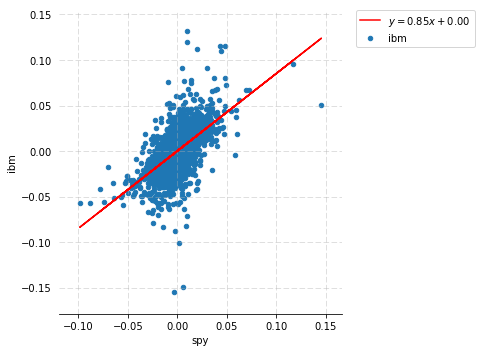

In [35]:
# the series to use to determine beta and alpha coeffecients
series = 'ibm'

# the series to benchmark returns against
benchmark = 'spy'

# create scatterplot
daily_returns.plot(kind='scatter', x=benchmark, y=series, figsize=square_figsize, label=series)

# create linear regression plot of series vs spy
beta, alpha = np.polyfit(x=daily_returns[benchmark], y=daily_returns[series], deg=1)

plt.plot(daily_returns[benchmark],
         beta * daily_returns[benchmark] + alpha,
         linestyle='-',
         color='r',
         label='$y = {0:.2f}x + {1:.2f}$'.format(beta, alpha))

print('(alpha = {})'.format(alpha))
print('(beta = {})'.format(beta))

plt.grid()
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

(alpha = 0.00016021239653457318)
(beta = 0.812082254835819)


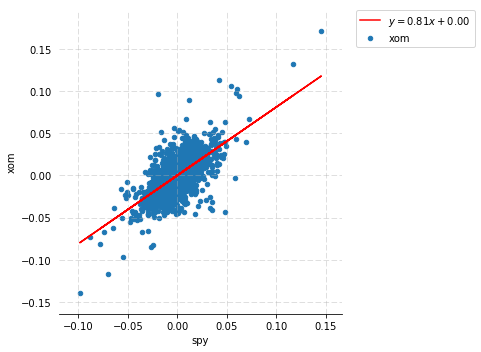

In [36]:
# the series to use to determine beta and alpha coeffecients
series = 'xom'

# the series to benchmark returns against
benchmark = 'spy'

# create scatterplot
daily_returns.plot(kind='scatter', x=benchmark, y=series, figsize=square_figsize, label=series)

# create linear regression plot of series vs spy
beta, alpha = np.polyfit(x=daily_returns[benchmark], y=daily_returns[series], deg=1)

plt.plot(daily_returns[benchmark],
         beta * daily_returns[benchmark] + alpha,
         linestyle='-',
         color='r',
         label='$y = {0:.2f}x + {1:.2f}$'.format(beta, alpha))

print('(alpha = {})'.format(alpha))
print('(beta = {})'.format(beta))

plt.grid()
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

### Correlations

Note how the GLD ETF has a very low correlation with most other tradable assets.

In [37]:
# review correlations of the daily returns series
corr = daily_returns.corr(method='pearson')
print(corr)

           spy      aapl       gld       ibm       xom
spy   1.000000  0.498219  0.030754  0.611857  0.642200
aapl  0.498219  1.000000 -0.008874  0.403942  0.249799
gld   0.030754 -0.008874  1.000000 -0.001436  0.128951
ibm   0.611857  0.403942 -0.001436  1.000000  0.356028
xom   0.642200  0.249799  0.128951  0.356028  1.000000


[[Top]](#Table-of-Contents)

---

## Sharpe ratio

An **annualised** measure of risk-adjusted returns.

\begin{align}
sr & = \frac{R_p - R_f}{\sigma} \\
& = \frac{E[R_p - R_f]}{\sigma} \\ 
& = \frac{mean(R_p - R_f)}{std(R_p)} \\ 
\end{align}

where:

 * $R_p$ = Daily returns
 * $R_f$ = Risk-free rate
 * $\sigma$ = Std deviation of daily returns
 * $R_p - R_f$ = Daily excess returns
 
further the risk free rate is typically one of the following:
 
 * LIBOR
 * 30-day T-Bill
 * 3-month T-Bill
 * 0% (zero -> modern day interst rates are near non-existant)


[[Top]](#Table-of-Contents)

### Sharpe ratio adjustment

The adjusment is $sr = sr * \sqrt{k}$, where $k$ is determined by the sampling frequency.

 * $k$ = 252 when using daily returns
 * $k$ = 52 when using weekly returns
 * $k$ = 12 when using monthly returns

Example using **daily** returns
\begin{align}
sr & = \sqrt{252} * \frac{R_p - R_f}{\sigma} \\
\end{align}


[[Top]](#Table-of-Contents)

### Risk free rate adjustment

Risk free rates, i.e. Treasury yields, are often quoted as an Effective Annual Rate (EAR). To convert the EAR into a daily retuns we use the following:

\begin{align}
rf & = \left[ (1 + EAR) ^ \frac{1}{k} \right] - 1 \\
\end{align}

where $k$ is determined by the sampling frequency:

 * Daily quotes: $k = 252$
 * Weekly quotes: $k = 52$
 * Monthly quotes: $k = 12$

[[Top]](#Table-of-Contents)

### Portfolio returns `rp`

Assume a buy and hold approach for each tradable asset individually investing $10,000 at the beginning of the holding period into each asset.

Note: this would cause \$10,000 to be allcoated to `gld` which isn't actually traded until 2004-11-08. This leaves $1 / 5$ (20%) of our funds not generating a return for 4+ years, which of course is a terrible idea.

Final values of holdings:
        2017-02-27
spy     $26,771.26
aapl $1,024,861.43
gld     $26,840.92
ibm     $26,039.09
xom     $35,107.67


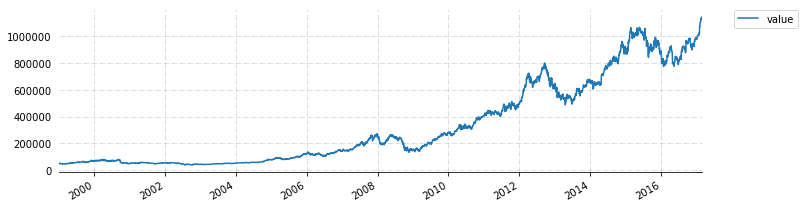

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4566 entries, 1999-01-05 to 2017-02-27
Data columns (total 1 columns):
rp    4566 non-null float64
dtypes: float64(1)
memory usage: 71.3 KB
None
                  rp
1999-01-05  0.017805
1999-01-06  0.004188
1999-01-07  0.015624
1999-01-08 -0.002456
1999-01-11 -0.004180

Mean daily portfolio return rp    0.000808
dtype: float64


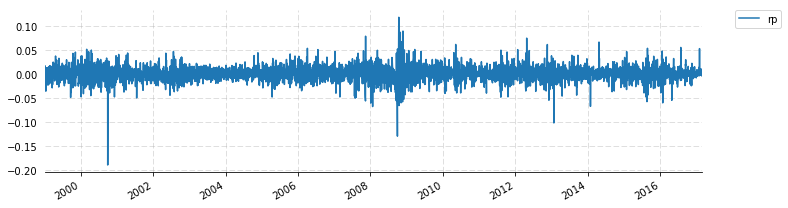

In [38]:
rp = norm * 10000

# display final holdings
pd.options.display.float_format = '${:,.2f}'.format
final_holdings = rp.ix[-1:,].transpose()
print('Final values of holdings:')
print(final_holdings)
pd.options.display.float_format = None

# determine portfolio value in $ at the end of each trading day
rp['value'] = rp.sum(axis=1)
rp['value'] .plot(**ts_kwargs)
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

# determine daily returns of the portfolio
rp = rp[['value']].pct_change()
rp = rp.rename(columns={'value': 'rp'})

# drops the first row, as there is no preceding data to determine returns
# for the first day in the series
rp = rp.dropna()

# review
print(rp.info())
print(rp.head())
print()
print('Mean daily portfolio return {0}'.format(rp.mean()))

# plot
rp.plot(**ts_kwargs)
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

### Risk free rate `rf`

Below, we get the yield for the 3-month treasury bill, quoted as an EAR on a daily basis. Quandl also has the 30-day yield, but the time series doesn't go back as far as the data we are using.

Quandl data a tag = [USTREASURY/YIELD](https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4566 entries, 1999-01-05 to 2017-02-27
Data columns (total 1 columns):
rf    4566 non-null float64
dtypes: float64(1)
memory usage: 71.3 KB
None
                  rf
1999-01-05  0.006773
1999-01-06  0.006766
1999-01-07  0.006744
1999-01-08  0.006773
1999-01-11  0.006795
Mean daily risk-free return rf    0.003123
dtype: float64


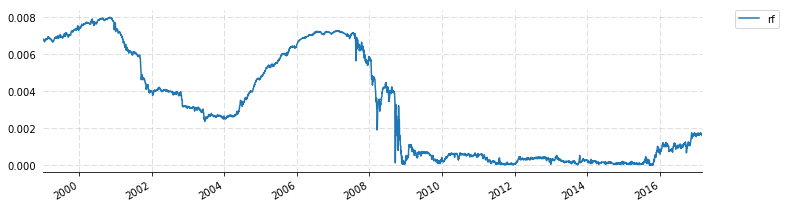

In [39]:
# create empty dataframe with dates to join to
# use the portfolio returns, this ensures index date alignment
# and an equal number of observations for the Sharpe ratio calc.
rf = pd.DataFrame(index=rp.index)

# get risk free rate
k = n_trading_days

# only return the 2nd column, '3 MO', and rename it to 'rf
rf = rf.join(quandl.get("USTREASURY/YIELD.2",
                start_date=start_date,
                end_date=end_date), method='left')

rf = rf.rename(columns={'3 MO': 'rf'})

# fill blanks
rf = rf.fillna(method='ffill', axis=0)
rf = rf.fillna(method='bfill', axis=0)

# convert EAR to daily risk-free rate
rf = (1 + rf) ** (1 / k) - 1

# review
print(rf.info())
print(rf.head())
print('Mean daily risk-free return {0}'.format(rf.mean()))

# plot
rf.plot(**ts_kwargs)
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

Review the excess returns over the risk-free rate. A quick review will let us know what to expect from our Sharpe ratio calculation.

Mean	Std Dev	Skew	Kurtosis
------	-------	------	---------
-0.002	0.016	-0.439	8.351


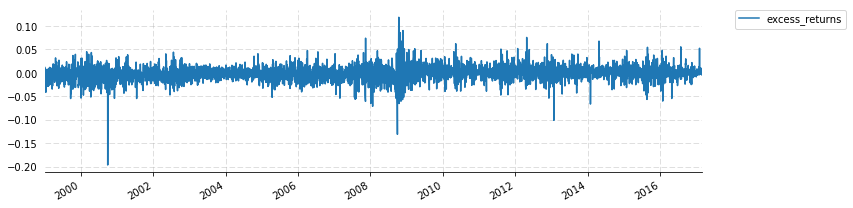

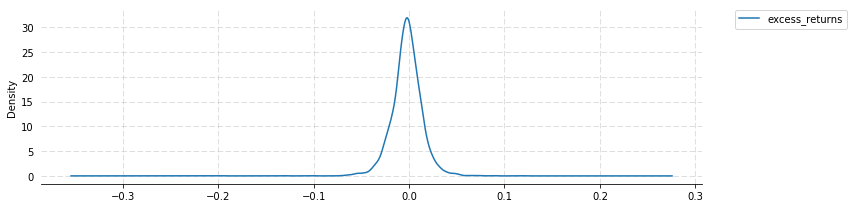

In [40]:
excess_returns = rp['rp'] - rf['rf']

# stats
er_mean = excess_returns.mean()
er_std = excess_returns.std()
er_skew = excess_returns.skew()
er_kurt = excess_returns.kurtosis()

print('Mean\tStd Dev\tSkew\tKurtosis')
print('------\t-------\t------\t---------')
print('{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}'.format(er_mean, er_std, er_skew, er_kurt))

# plots
excess_returns.plot(label='excess_returns', **ts_kwargs)
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

excess_returns.plot(kind='kde', label='excess_returns', **ts_kwargs)
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

### Sharpe ratio calculation `sr`

In [41]:
sr = np.sqrt(n_trading_days) * np.mean((excess_returns)) / np.std(rp.values)
print('Sharpe ratio: {}'.format(sr))

Sharpe ratio: -2.3454837901963557


The above is the same as the code below.

In [42]:
sr = np.sqrt(n_trading_days) * np.mean(rp.values - rf.values) / np.mean(np.std(rp.values))
print('Sharpe ratio: {}'.format(sr))

Sharpe ratio: -2.3454837901963557


This negative result means the portfolio performed worse than the risk-free rate over the holding period. We could've determined this would occur by quickly reviewing the means of the `rp` and `rf` time series, where we see that the mean daily portfolio return is less than the mean daily risk-free return.


In [43]:
rp.mean()

rp    0.000808
dtype: float64

In [44]:
rf.mean()

rf    0.003123
dtype: float64

[[Top]](#Table-of-Contents)

---

## Optimising functions

Read the following page to understand what is happening below: [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html)

In [45]:
def f(X, trace=False):
        """The model"""
        Y = (X - 1.5) ** 2 + 0.5
        
        # allow for a the results to be printed iteratively
        if trace == True:
            print('X = {0}, Y = {1}'.format(X, Y))
        
        return Y

In [46]:
# parameter into the optimisation routine
x_guess = 2.0

# perform optimisation
min_result = spo.minimize(fun=f,
                          x0=x_guess,
                          args=(True),
                          method='SLSQP',
                          options={'disp': True})

# review
print('Minima found at:')
print('X = {}, Y = {}'.format(min_result.x, min_result.fun))

X = [ 2.], Y = [ 0.75]
X = [ 2.], Y = [ 0.75]
X = [ 2.00000001], Y = [ 0.75000001]
X = [ 0.99999999], Y = [ 0.75000001]
X = [ 1.5], Y = [ 0.5]
X = [ 1.5], Y = [ 0.5]
X = [ 1.50000001], Y = [ 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [ 0.5]
            Iterations: 2
            Function evaluations: 7
            Gradient evaluations: 2
Minima found at:
X = [ 1.5], Y = [ 0.5]


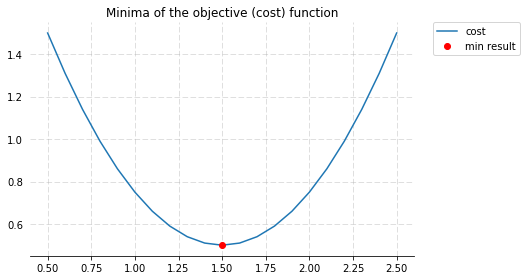

In [47]:
# create y values using our model function
x_plot = np.linspace(0.5, 2.5, 21)
y_plot = f(x_plot)

# plot the cost functioin
plt.plot(x_plot, y_plot, label='cost')

# plot the optimisation result
plt.plot(min_result.x, min_result.fun, 'ro', label='min result')

# plot
plt.grid()
plt.title('Minima of the objective (cost) function')
plt.legend(**legend_kwargs)
plt.tight_layout()
plt.show()

[[Top]](#Table-of-Contents)

### Optimisation ranges and constraints

#### Ranges

 * Ranges limit the values of $x$ within which to perform the optimisation search.
 * `for x in range(0, 10):`
 
#### Constraints

 * Constraints are properties of $x$ that must be `True`
 * e.g. $\sum_{x=0}^n x= 1$

[[Top]](#Table-of-Contents)

### Framing the optimisation problem

We need to know what we're optimising for:

 * Sharpe ratio is our objective.
 * However, we want to maximise the Sharpe ratio, therefore when optimising we would need to mulitply by negative 1.
 * Based on the above, **the coeffecients returned are the desired asset allocations in the portfolio** that maximise the Sharpe ratio.
 

[[Top]](#Table-of-Contents)